In [35]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [36]:
# create GEKKO model
m = GEKKO()

In [37]:
# constants
sm = 22.0 #maximal VO2
e0 = 2000 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
distance = 20000 #final horizontal distance to cover [m]
mass = 55 #body mass
tau = 0.67

expected_finish_time = 1.5 * 60 * 60 #technical - expected solution
maximal_finish_time = 3.5 * 60 * 60 #technical - maximal finish time

In [38]:
# parameters
k = 0.03734

In [39]:
# time points [s]
nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

In [40]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

In [41]:
# slope data to create spline
x_data = np.linspace(0, distance, 500)
slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

In [42]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=7.0) #velocity
E = m.Var(value=e0, lb=0.0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=0.00201818, lb=0.0) # oxidation rate
sigma = m.Var(value=sm, lb=0) #breathing rate
sigma_max = m.Var() #limit of sigma value
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [43]:
# FV - final time
tf = m.FV(value=expected_finish_time,lb=0.1,ub=maximal_finish_time)
tf.STATUS = 1

In [44]:
# MV
u = m.MV(value=0,lb=0,ub=9.6)
u.STATUS = 1

In [45]:
# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [46]:
# equations
m.Equation(v.dt()==(u - g * m.sin(slope) - v/tau)*tf)
m.Equation(E.dt()==(sigma - u*v + N * 4 * 4184 * 1/mass) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(k*N*(0.0222-N))*tf)
m.Equation(sigma<=sigma_max)
m.Equation((distance-x)*final<=0)
m.Equation(sigma - u*v + N * 4 * 4184 * 1/mass <= 0)

In [47]:
# objective
m.Minimize(tf)

In [48]:
m.options.IMODE = 6
m.options.MAX_ITER=15000
m.solve()

print('Final Time: ' + str(tf.value[0]))

apm 46.215.0.157_gk_model2 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           13
   Intermediates:            0
   Connections  :            4
   Equations    :            8
   Residuals    :            8
 
 Number of state variables:           1901
 Number of total equations: -         1700
 Number of slack variables: -          300
 ---------------------------------------
 Degrees of freedom       :            -99
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This p

Scaling factors are invalid - setting them all to 1.
  55  3.5661885e+05 1.49e+05 6.76e+19   7.7 1.56e+03  19.4 9.90e-01 1.65e-03h  1
Scaling factors are invalid - setting them all to 1.
  56r 3.5661885e+05 1.49e+05 1.00e+03   7.7 0.00e+00  19.8 0.00e+00 0.00e+00R  1
  57r 3.5931636e+05 1.05e+05 3.19e+02   1.7 4.47e+04    -  9.89e-01 9.76e-01f  1
  58r 4.5180712e+05 1.26e+05 1.20e+05   3.9 8.17e+01   2.0 9.42e-01 3.26e-02f  1
  59r 4.8947810e+05 1.20e+05 2.43e+03   2.9 3.31e+01   1.5 9.88e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r 4.8364926e+05 1.06e+05 1.00e+03   1.4 9.04e+01   1.0 9.93e-01 1.00e+00f  1
  61r 4.7011067e+05 1.03e+05 1.00e+03   0.5 2.70e+02   0.6 1.00e+00 1.00e+00f  1
  62r 4.6900402e+05 1.02e+05 1.00e+03  -0.4 8.12e+02   0.1 1.00e+00 6.28e-02f  1
  63r 4.6835449e+05 1.02e+05 1.00e+03  -0.4 2.79e+03  -0.4 1.00e+00 1.69e-02f  1
  64r 4.5557290e+05 1.02e+05 1.00e+03   0.2 8.37e+03  -0.9 1.00e+00 6.80e-02f  1
  6

Scaling factors are invalid - setting them all to 1.
 157  5.0464512e+05 8.58e+03 1.96e+10   7.8 2.00e+04    -  3.32e-01 3.69e-01H  1
Scaling factors are invalid - setting them all to 1.
 158  5.2585228e+05 6.70e+03 1.37e+10   7.1 7.08e+03    -  2.10e-01 4.79e-01h  1
Scaling factors are invalid - setting them all to 1.
 159  5.5096677e+05 1.03e+04 1.91e+09   6.4 1.08e+04    -  5.01e-01 7.84e-01h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.7861885e+05 9.98e+02 2.94e+09   6.7 2.68e+03    -  9.99e-01 9.49e-01h  1
Scaling factors are invalid - setting them all to 1.
 161  5.9246844e+05 7.62e+02 2.91e+09   6.3 3.20e+03    -  9.22e-01 2.34e-01h  2
Scaling factors are invalid - setting them all to 1.
 162  5.9768300e+05 5.37e+03 2.54e+09   5.4 2.50e-01   8.0 1.00e+00 1.00e+00H  1
Scaling factors are invalid - setting them all to 1.
 163  6.1600224e+05 4.65e+03 4.11e+09   6.1 2.79e+03    -  1.0

 268  6.4908564e+05 2.41e+01 2.71e+08   0.1 1.92e+00   4.6 9.90e-01 1.00e+00h  1
 269  6.4905200e+05 4.66e+00 4.42e+05   0.1 6.10e-02   6.0 9.92e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  6.4888794e+05 4.66e+00 9.82e+06   0.1 2.35e-01   5.5 1.00e+00 1.00e+00H  1
 271  6.4869988e+05 1.16e+01 5.87e+05   0.1 9.70e-01   5.0 1.00e+00 1.00e+00f  1
 272  6.4868493e+05 1.01e+01 5.14e+05   0.1 2.91e+00   4.5 1.00e+00 1.25e-01h  4
 273  6.4867209e+05 9.74e+00 5.03e+05   0.1 7.28e+00   4.0 1.00e+00 2.17e-02h  6
 274  6.4866080e+05 9.60e+00 5.00e+05   0.1 1.57e+01   3.6 1.00e+00 4.99e-03h  7
 275  6.4864059e+05 9.51e+00 4.99e+05   0.1 2.99e+01   3.1 1.44e-01 2.72e-03h  7
 276  6.4857694e+05 9.39e+00 4.97e+05   0.1 5.98e+01   2.6 2.23e-01 3.05e-03f  6
 277  6.4841946e+05 9.27e+00 4.99e+05   0.1 1.51e+02   2.1 4.19e-02 2.90e-03f  5
 278  6.4824021e+05 9.23e+00 5.02e+05   0.1 4.97e+02   1.7 1.84e-02 9.78e-04f  5
 279  6.4817198e+05 9.17e+00

 361  6.4108154e+05 5.57e+01 1.03e+07   0.1 1.42e+02   1.8 3.44e-01 1.46e-04h 12
 362  6.3083548e+05 8.50e+01 9.82e+06   0.1 2.54e+02   1.3 1.73e-02 6.58e-02f  2
 363  6.2739916e+05 9.04e+01 9.82e+06   0.1 3.54e+02   0.8 1.16e-04 9.46e-03f  4
 364  6.2665060e+05 9.03e+01 9.21e+06   0.1 2.39e+02   1.3 1.69e-01 5.70e-03h  6
 365  6.2656084e+05 9.03e+01 9.19e+06   0.1 7.52e+02   0.8 1.11e-03 9.25e-05h  8
 366  6.2561871e+05 9.02e+01 7.77e+06   0.1 2.50e+02   1.2 4.21e-01 6.31e-03h  6
 367  6.1570755e+05 3.48e+02 7.89e+06   0.1 1.16e+03   0.7 1.06e-03 6.78e-03w  1
 368  5.8635117e+05 6.14e+02 6.37e+06   0.1 2.52e+02   1.2 1.75e-01 2.33e-01w  1
 369  5.8771489e+05 3.91e+02 1.37e+08   0.1 2.62e-01   7.0 1.88e-01 4.72e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  5.8923631e+05 2.26e+02 2.18e+08   1.7 1.40e-01   7.4 1.00e+00 1.00e+00f  1
 371  5.8993920e+05 1.37e+02 5.57e+08   2.4 1.11e-01   7.0 1.00e+00 1.00e+00f  1
 372  5.9000019e+05 9.32e+01

Scaling factors are invalid - setting them all to 1.
 455  3.4666737e+05 3.85e+04 1.20e+09   7.0 1.07e+04    -  6.22e-01 3.05e-01h  1
Scaling factors are invalid - setting them all to 1.
 456  3.7447486e+05 2.41e+04 2.69e+09   6.9 2.18e+04    -  2.22e-01 3.48e-01h  1
Scaling factors are invalid - setting them all to 1.
 457  3.7492641e+05 2.40e+04 3.18e+09   6.2 2.99e+02   8.3 2.91e-02 4.11e-03h  1
Scaling factors are invalid - setting them all to 1.
 458  3.8239801e+05 2.24e+04 6.14e+10   5.5 2.98e+02   7.8 2.11e-01 6.79e-02h  1
Scaling factors are invalid - setting them all to 1.
 459  4.0350785e+05 1.88e+04 1.43e+11   4.8 2.75e+02   7.3 2.96e-01 1.86e-01h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  4.3383195e+05 1.49e+04 4.99e+10   4.1 2.16e+02   6.9 3.45e-01 2.49e-01h  1
Scaling factors are invalid - setting them all to 1.
 461  4.7256504e+05 1.17e+04 7.22e+10   3.4 1.49e+02   6.4 3.8

 560  5.2307311e+05 1.49e+04 2.79e+10  -3.8 1.71e+00  10.2 8.83e-02 3.97e-01h  1
Scaling factors are invalid - setting them all to 1.
 561  5.2307980e+05 1.49e+04 2.79e+10  -3.8 2.73e+02   9.7 3.52e-06 8.05e-05h  1
Scaling factors are invalid - setting them all to 1.
 562r 5.2307980e+05 1.49e+04 9.99e+02   2.0 0.00e+00   9.3 0.00e+00 6.77e-09R  2
 563r 5.2809707e+05 1.47e+04 9.97e+02  -0.3 5.16e+04    -  5.41e-03 9.28e-04f  1
Scaling factors are invalid - setting them all to 1.
 564  5.2523057e+05 1.51e+04 1.00e+02  -3.8 2.73e+06    -  2.73e-03 1.48e-04f  1
 565  5.1791988e+05 1.54e+04 9.97e+01  -3.8 7.49e+05    -  6.73e-06 2.56e-03f  1
 566  5.1816696e+05 1.52e+04 3.28e+07  -3.8 3.63e+00   8.8 5.98e-01 1.45e-02h  1
Scaling factors are invalid - setting them all to 1.
In iteration 566, 1 Slack too small, adjusting variable bound
 567  5.1816696e+05 1.52e+04 3.28e+07  -3.8 3.13e+02   8.3 1.25e-04 4.67e-10h  1
Scaling factors are invalid - setting them all to 1.
 568  5.1819025e+05 1.52e

Scaling factors are invalid - setting them all to 1.
 647  5.1681112e+05 6.52e-02 3.38e-01  -6.6 3.40e-01  -0.6 1.00e+00 1.00e+00h  1
 648  5.1652795e+05 9.39e-02 3.11e+01  -6.2 9.77e-01  -1.1 1.00e+00 2.99e-01h  1
Scaling factors are invalid - setting them all to 1.
 649  5.1649022e+05 9.34e-02 3.48e+01  -5.7 2.68e+00  -1.6 1.00e+00 1.45e-02h  1
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  5.1627656e+05 1.33e-01 2.53e+01  -5.8 4.39e+00  -2.1 1.00e+00 5.02e-02f  1
Scaling factors are invalid - setting them all to 1.
 651  5.1582747e+05 5.15e-01 2.58e+01  -5.3 5.44e+00  -2.6 1.00e+00 8.53e-02f  1
 652  5.1580824e+05 5.09e-01 2.08e+01  -3.7 1.31e+01  -2.1 1.00e+00 9.96e-03f  1
 653  5.1610178e+05 5.81e-01 4.66e+06  -2.1 3.42e+00  -0.8 1.00e+00 8.87e-02f  1
 654  5.1627172e+05 6.35e+02 5.36e+07  -2.2 1.45e+03    -  9.99e-02 1.00e+00f  1
 655  5.1665777e+05 8.08e-01 5.36e+07  -2.2 4.56e+00  -1.3 

Scaling factors are invalid - setting them all to 1.
 729  6.1271153e+05 3.95e+04 7.77e+13   1.5 1.23e+03   8.7 7.49e-02 2.31e-03h  4
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  6.2437433e+05 3.84e+04 7.23e+13   1.5 2.77e+02   9.1 1.58e-01 2.49e-02h  2
Scaling factors are invalid - setting them all to 1.
 731  6.2875498e+05 3.82e+04 7.18e+13   1.5 6.53e+02   8.6 5.99e-02 4.61e-03h  1
Scaling factors are invalid - setting them all to 1.
 732  6.3083498e+05 3.81e+04 7.16e+13   1.5 1.17e+03   8.1 6.29e-02 2.04e-03h  1
Scaling factors are invalid - setting them all to 1.
 733  6.3292816e+05 3.79e+04 7.10e+13   1.5 1.51e+03   7.7 3.12e-02 5.47e-03h  1
Scaling factors are invalid - setting them all to 1.
 734  6.3294591e+05 3.79e+04 7.10e+13   1.5 7.23e+03   7.2 6.83e-03 2.54e-05h  1
Scaling factors are invalid - setting them all to 1.
 735  6.3308840e+05 3.79e+04 7.10e+13   1.5 1.26e+03   7.6 4.2

 808  6.4364989e+05 1.07e+01 2.81e+07   0.1 5.58e+02   1.3 4.37e-03 2.22e-02w  1
 809  6.4365240e+05 8.31e+00 2.48e+07   0.1 2.67e+00   6.3 8.04e-01 2.00e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  6.4366807e+05 5.99e+02 1.13e+10   0.1 7.47e+01   6.7 6.53e-05 2.22e-02w  1
 811  6.4138014e+05 6.38e-01 2.80e+05   0.1 1.59e+00   6.2 4.37e-03 1.39e-03f  4
 812  6.4151432e+05 6.36e-01 6.63e+04   0.1 1.16e-01   5.8 9.98e-01 8.90e-01h  1
 813  6.4197698e+05 7.94e-01 7.49e+04   0.1 3.69e-01   5.3 1.00e+00 1.00e+00H  1
 814  6.4201659e+05 8.09e-01 7.50e+04   0.1 1.24e+00   4.8 1.00e+00 2.67e-02h  6
 815  6.4206014e+05 8.24e-01 7.50e+04   0.1 3.68e+00   4.3 1.00e+00 9.84e-03h  6
 816  6.4209377e+05 8.33e-01 7.50e+04   0.1 1.08e+01   3.9 1.00e+00 2.61e-03h  7
 817  6.4215991e+05 8.44e-01 8.41e+04   0.1 3.07e+01   3.4 1.00e+00 1.88e-03h  9
 818  6.4222976e+05 8.51e-01 7.50e+04   0.1 8.09e+01   2.9 6.54e-01 8.27e-04h 10
 819  6.4229332e+05 8.55e-01

 905  6.4809753e+05 1.15e+00 1.41e+05   0.1 4.07e-02   6.5 9.93e-01 9.93e-01s 22
 906  6.4822407e+05 1.16e+00 1.45e+05   0.1 1.25e-01   6.1 1.00e+00 1.00e+00s 22
 907r 6.4822407e+05 1.16e+00 1.00e+03   0.1 0.00e+00   5.6 0.00e+00 0.00e+00R  1
 908r 6.4659923e+05 1.13e+00 8.13e+02   0.0 4.93e+02    -  1.00e+00 1.18e-01f  1
 909  6.4659719e+05 1.13e+00 6.24e+03   0.1 6.54e+03    -  7.06e-01 3.10e-04f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  6.4655149e+05 1.13e+00 1.01e+04   0.1 3.25e+03    -  9.88e-01 1.95e-03h 10
 911  6.3300512e+05 4.36e+02 7.93e+03   0.1 7.28e+03    -  9.90e-01 2.50e-01f  3
 912  6.3302424e+05 4.36e+02 7.93e+03   0.1 2.98e+02   5.1 1.47e-04 1.16e-04h  2
 913  6.3289657e+05 4.11e+02 5.64e+04   0.1 1.16e+00   4.6 9.90e-01 5.61e-02h  3
 914  6.3287691e+05 4.05e+02 7.33e+04   0.1 3.20e+00   4.2 9.90e-01 1.43e-02h  7
 915  6.3287906e+05 4.05e+02 7.83e+04   0.1 7.81e+00   3.7 1.00e+00 9.77e-04h 11
 916  6.3288516e+05 4.05e+02

 999  8.5418415e+05 1.62e+03 7.06e+05   0.1 8.74e+01   1.5 1.00e+00 3.21e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  7.1979400e+05 1.29e+02 5.20e+04   0.1 7.24e+01   1.1 1.00e+00 1.07e-02h  6
1001  7.2143094e+05 1.27e+02 4.85e+04   0.1 1.78e+02   1.5 1.00e+00 1.23e-02h  7
1002  7.2336374e+05 1.24e+02 4.84e+04   0.1 1.22e+02   1.9 1.00e+00 1.77e-02h  6
1003  7.2507171e+05 1.22e+02 4.67e+04   0.1 1.79e+02   1.4 1.00e+00 1.30e-02h  7
1004  7.2698235e+05 1.19e+02 4.75e+04   0.1 1.27e+02   1.9 1.00e+00 1.69e-02h  6
1005  7.2858955e+05 1.17e+02 4.40e+04   0.1 1.78e+02   1.4 1.00e+00 1.26e-02h  7
1006  7.3044420e+05 1.15e+02 4.95e+04   0.1 1.32e+02   1.8 1.00e+00 1.59e-02h  6
1007  7.3172976e+05 1.13e+02 4.10e+04   0.1 1.75e+02   1.3 1.00e+00 1.05e-02h  7
1008  7.3347140e+05 1.11e+02 5.27e+04   0.1 1.36e+02   1.8 1.00e+00 1.45e-02h  6
1009  7.3513960e+05 1.09e+02 4.02e+04   0.1 1.71e+02   1.3 6.73e-01 1.48e-02h  6
iter    objective    inf_pr 

1092  8.4518443e+05 2.70e+01 4.36e+04  -0.6 1.41e+01   1.4 7.08e-02 1.53e-01w  1
1093  8.6409903e+05 7.26e-02 3.13e+04  -0.6 6.98e+00   1.8 5.43e-02 1.43e-03f  8
1094  8.6400939e+05 7.40e-02 3.75e+04  -0.6 3.32e+01   1.4 2.09e-02 2.00e-03f  8
1095  8.6393923e+05 7.49e-02 4.14e+04  -0.6 2.40e+01   1.8 7.79e-01 3.10e-03h  9
1096  8.6385734e+05 7.60e-02 4.13e+04  -0.6 3.35e+01   1.3 1.19e-02 1.47e-03f  8
1097  8.6378291e+05 7.70e-02 3.84e+04  -0.6 2.51e+01   1.7 2.91e-01 3.11e-03h  9
1098  8.6372960e+05 7.74e-02 4.07e+04  -0.6 6.45e+01   1.3 2.00e-03 3.70e-04f  8
1099  8.6365423e+05 7.84e-02 3.32e+04  -0.6 2.63e+01   1.7 8.98e-01 2.97e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  8.6358113e+05 7.93e-02 2.30e+04  -0.6 1.59e+01   2.1 5.28e-01 4.97e-03h  6
1101  8.6350814e+05 8.03e-02 3.04e+04  -0.6 2.74e+01   1.6 1.57e-01 2.73e-03h  9
1102  8.6342933e+05 8.13e-02 2.20e+04  -0.6 1.70e+01   2.1 1.00e+00 5.01e-03h  8
1103  8.5229679e+05 2.79e+01

1186  8.5952348e+05 1.20e-01 2.92e+04  -0.6 2.20e+01   1.7 1.00e+00 3.31e-03h  9
1187  8.5945986e+05 1.21e-01 2.84e+04  -0.6 1.30e+01   2.1 1.00e+00 5.37e-03h  6
1188  8.5937639e+05 1.22e-01 3.01e+04  -0.6 2.29e+01   1.7 2.61e-01 3.74e-03h  8
1189  8.5928585e+05 1.23e-01 2.86e+04  -0.6 1.40e+01   2.1 1.00e+00 7.13e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1190  8.5924210e+05 1.23e-01 2.99e+04  -0.6 2.38e+01   1.6 1.89e-01 1.84e-03h  9
1191  8.5913616e+05 1.25e-01 2.83e+04  -0.6 1.49e+01   2.0 1.00e+00 7.81e-03h  8
1192  8.5909342e+05 1.25e-01 2.94e+04  -0.6 2.46e+01   1.6 1.20e-01 1.68e-03h  9
1193  8.5903698e+05 1.25e-01 2.82e+04  -0.6 1.58e+01   2.0 1.00e+00 3.91e-03h  9
1194  8.4708133e+05 3.39e+01 2.74e+04  -0.6 2.54e+01   1.5 8.25e-02 4.32e-01w  1
1195  8.4320359e+05 2.08e+01 5.18e+04  -0.6 8.21e+00   1.9 1.95e-01 5.19e-01w  1
1196  8.4306523e+05 2.05e+01 5.10e+04  -0.6 8.23e+00   1.5 5.27e-02 1.29e-02w  1
1197  8.5899028e+05 1.25e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  8.5431875e+05 1.69e-01 2.18e+04  -0.6 1.20e+01   2.0 1.00e+00 7.81e-03h  8
1281  8.5427607e+05 1.69e-01 2.19e+04  -0.6 1.96e+01   1.5 9.15e-02 1.96e-03h  9
1282  8.5418604e+05 1.70e-01 2.16e+04  -0.6 1.28e+01   2.0 1.00e+00 7.81e-03h  8
1283  8.5411087e+05 1.70e-01 2.21e+04  -0.6 2.02e+01   1.5 6.30e-02 3.09e-03h  8
1284  8.5401579e+05 1.71e-01 2.14e+04  -0.6 1.35e+01   1.9 1.00e+00 7.75e-03h  8
1285  8.4572129e+05 1.94e+01 3.16e+04  -0.6 2.05e+01   1.4 4.09e-02 2.94e-01w  1
1286  8.4555946e+05 1.90e+01 3.05e+04  -0.6 8.50e+00   1.9 1.80e-01 1.95e-02w  1
1287  8.4505849e+05 1.87e+01 2.99e+04  -0.6 1.65e+01   1.4 7.14e-03 1.86e-02w  1
1288  8.5395099e+05 1.72e-01 2.38e+04  -0.6 8.51e+00   1.8 4.09e-02 2.29e-03h  7
1289  8.5386556e+05 1.73e-01 2.40e+04  -0.6 4.22e+01   1.3 1.52e-03 9.40e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1290  8.5381244e+05 1.73e-01

1374  8.2205511e+05 2.74e+00 2.84e+05  -0.6 2.68e+00   2.3 2.96e-02 4.18e-01f  1
1375  8.2189536e+05 2.74e+00 2.84e+05  -0.6 1.88e+03   1.8 8.89e-05 7.79e-05f  2
1376  8.1922936e+05 4.35e+00 1.34e+05  -0.6 5.98e+00   2.3 6.28e-02 4.94e-01f  1
1377  8.1870500e+05 2.40e+00 6.35e+04  -0.6 1.84e+00   2.7 7.18e-01 5.00e-01f  2
1378  8.1730361e+05 2.23e+00 2.63e+04  -0.6 7.47e+00   2.2 5.08e-01 3.74e-01H  1
1379  8.1726222e+05 2.23e+00 2.62e+04  -0.6 4.71e+01   1.7 1.19e-01 1.41e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380  8.1657934e+05 2.21e+00 1.84e+04  -0.6 5.94e+00   2.2 7.76e-01 2.09e-01h  1
1381  8.1649668e+05 2.20e+00 1.83e+04  -0.6 2.17e+01   1.7 3.04e-01 7.40e-03h  4
1382  8.1602213e+05 1.95e+00 1.86e+04  -0.6 4.68e+00   2.1 1.00e+00 2.32e-01h  1
1383  8.1596032e+05 1.93e+00 2.81e+04  -0.6 4.76e+00   1.6 1.00e+00 1.44e-02h  1
1384  8.1569875e+05 1.42e+00 1.53e+04  -0.6 1.65e+00   2.1 1.00e+00 3.06e-01h  1
1385  8.1489596e+05 1.03e+00

1472  5.0486578e+05 3.36e+01 2.89e+00  -4.5 9.23e+02    -  1.00e+00 7.28e-01h  1
1473  5.0486579e+05 2.91e+01 6.14e+03  -4.5 3.61e-01  -0.9 4.99e-02 1.34e-01h  1
1474  5.0486584e+05 2.42e+01 2.85e+03  -4.5 5.82e-01  -1.4 3.96e-01 1.67e-01h  1
1475  5.0486598e+05 1.08e+01 7.69e+02  -4.5 5.21e-01  -1.9 8.07e-01 5.52e-01h  1
1476  5.0486597e+05 1.06e+01 2.04e+03  -4.5 1.27e-01  -0.6 6.78e-01 1.88e-02h  1
1477  5.0486594e+05 7.49e+00 1.52e+03  -4.5 2.16e-01  -1.1 5.41e-01 2.95e-01h  1
1478  5.0486540e+05 6.91e+00 1.40e+03  -4.5 1.54e-01   1.2 4.50e-02 7.85e-02h  1
1479  5.0486476e+05 5.89e+00 1.18e+03  -4.5 1.41e-01   0.7 4.60e-02 1.48e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  5.0486479e+05 5.15e+00 1.09e+03  -4.5 1.80e-01   0.2 8.26e-01 1.25e-01h  1
1481  5.0486506e+05 3.94e+00 8.33e+02  -4.5 1.59e-01  -0.3 6.86e-01 2.36e-01h  1
1482  5.0486601e+05 4.23e-02 8.78e+00  -4.5 1.23e-01  -0.7 1.00e+00 1.00e+00h  1
1483  5.0486614e+05 9.63e-03

In [52]:
tm = tm * tf.value[0]

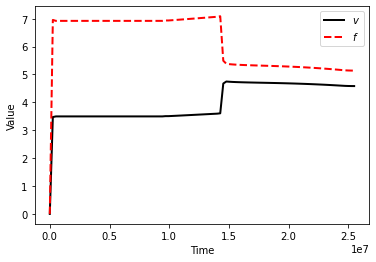

In [53]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

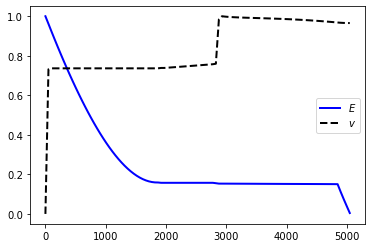

In [51]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.legend()
plt.show()

In [54]:
5047 / 60 / 60

1.4019444444444444